# Word2Vec 


## Модель дистрибутивной семантики. Реализация с помощью PyTorch

In [12]:
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

In [29]:
import re
import collections

Датасет - англоязычный набор данных Рецепты еды.

Его рассматривают на семинаре.

Источник: [https://github.com/nytimes/ingredient-phrase-tagger/tree/master]

In [16]:
full_dataset = list(pd.read_csv('../dataset/receipts.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_data = full_dataset[:TRAIN_VAL_SPLIT]
test_data = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_data))
print("Тестовая выборка", len(test_data))
print()
print('\n'.join(train_data[:5]))

Обучающая выборка 125344
Тестовая выборка 53719

1/2 teaspoon paprika
2 teaspoons paprika
2 cups cooked black beans, drained (canned are fine)
2 tablespoons butter
1 teaspoon ground coriander


## Токенизация

In [17]:
TOKEN_RE = re.compile(r'[\w\d]+') 

def tokenize_text_simple_regex(txt, min_token_size=4):
    #print(txt)
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]

def character_tokenize(txt): 
    return list(txt)

def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs): 
    #print(texts)
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]

In [24]:
# токенизируем
train_tokens = tokenize_corpus(train_data)
test_tokens = tokenize_corpus(test_data)

In [25]:
train_tokens[2]

['cups', 'cooked', 'black', 'beans', 'drained', 'canned', 'fine']

## Словарь из ингредиентов рецепта

In [27]:
# Метод, написанный преподавателями курса
def build_vocabulary(tokenized_texts, max_size=50000, max_doc_freq=0.8, min_count=5, pad_word=None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq


PAD_TOKEN = '__PAD__'
NUMERIC_TOKEN = '__NUMBER__'
NUMERIC_RE = re.compile(r'^([0-9.,e+\-]+|[mcxvi]+)$', re.I)

In [32]:
vocabulary, word_doc_freq = build_vocabulary(train_tokens, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2252
[('<PAD>', 0), ('tablespoons', 1), ('teaspoon', 2), ('chopped', 3), ('salt', 4), ('pepper', 5), ('cups', 6), ('ground', 7), ('tablespoon', 8), ('fresh', 9)]


#### PAD символ предназначен для выравнивания массивов в одну размерность для  преобразования в матрицу, облегчая обработку GPU

## Пронумирование токенов

In [36]:
def add_fake_token(word2id, token='<PAD>'):
    word2id_new = {token: i + 1 for token, i in word2id.items()}
    word2id_new[token] = 0
    return word2id_new


def texts_to_token_ids(tokenized_texts, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in tokenized_texts]


In [37]:
train_tkn_id = texts_to_token_ids(train_tokens, vocabulary)
test_tkn_id = texts_to_token_ids(test_tokens, vocabulary)


### Длины текстов

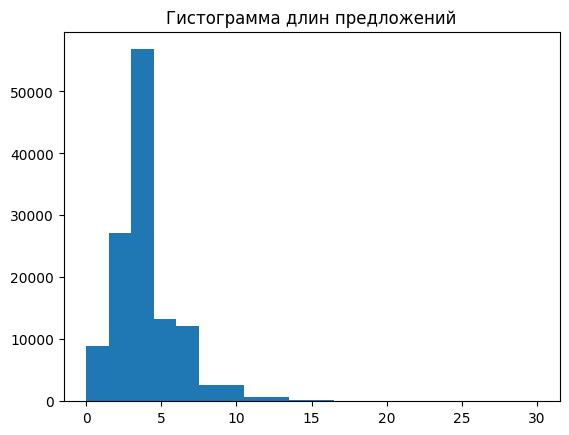

In [40]:
plt.hist([len(element) for element in train_tkn_id], bins=20);
plt.title('Гистограмма длин предложений');

## Преобразование в Тензор, для параллельной обработки

In [49]:
### Класс, разработанный преподавтелями курса.

### Решаемые задачи, благодаря новому классу.
#### Формирование датасета, каждой предложение в котором будет имеет одинкаовую длину 
#### Преобразование в Тензоре, что упростит обработку для GPU
import torch
from torch.utils.data import Dataset


def ensure_length(txt, out_len, pad_value):
    if len(txt) < out_len:
        txt = list(txt) + [pad_value] * (out_len - len(txt))
    else:
        txt = txt[:out_len]
    return txt


class PaddedSequenceDataset(Dataset):
    def __init__(self, texts, targets, out_len=100, pad_value=0):
        self.texts = texts
        self.targets = targets
        self.out_len = out_len
        self.pad_value = pad_value

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        txt = self.texts[item]

        txt = ensure_length(txt, self.out_len, self.pad_value)
        txt = torch.tensor(txt, dtype=torch.long)

        target = torch.tensor(self.targets[item], dtype=torch.long)

        return txt, target


In [50]:
MAX_SENTENCE_LEN = 20
train_info = PaddedSequenceDataset(train_tkn_id,
                                      np.zeros(len(train_tkn_id)),
                                      out_len=MAX_SENTENCE_LEN)
test_info = PaddedSequenceDataset(test_tkn_id,
                                     np.zeros(len(test_tkn_id)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_info[0])

(tensor([  2, 199,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]), tensor(0))


## Алгоритм Word2Vec и обучение

### Реализация Word2Vec включает в себя два важных механизма:
- Skip Gram - предсказание соседних слов на основе центрального в рамках скользящего окна
- Negative Sampling - апроксимация softmax с построением распределения вероятностей и определением сходства




Задача обучения word2vec сводится к созданию класификатора, 
принимающий на вход два идентификатора слова, и отвечающий на вопроса совместно ли они расположены


In [58]:
### Моделирование прохождения скользящего окна
### Легче отследить факт совместной встречаемости

def diagonal_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

diagonal_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

In [59]:
### Класс, разработанный преподавтелями курса.
### Реализация алгоритма SkipGram-NegativeSampling
class Trainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = diagonal_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

In [60]:
trainer = Trainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=5, negative_samples_n=25)

## методы из курсы, перенесенные с github

In [62]:
import copy
import datetime
import random
import traceback
import numpy as np
import torch
from torch.utils.data import DataLoader

def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)



            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model


def predict_with_model(model, dataset, device=None, batch_size=32, num_workers=0, return_labels=False):
    """
    :param model: torch.nn.Module - обученная модель
    :param dataset: torch.utils.data.Dataset - данные для применения модели
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :return: numpy.array размерности len(dataset) x *
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []
    with torch.no_grad():
        import tqdm
        for batch_x, batch_y in tqdm.tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = copy_data_to_device(batch_x, device)

            if return_labels:
                labels.append(batch_y.numpy())

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)
        
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))

## Построение модели Word2Vec через PyTorch

In [67]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_info,
                                            test_info,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=35,
                                            batch_size=8,
                                            device='cpu',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_info),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 2001 итераций, 12.35 сек
Среднее значение функции потерь на обучении 0.8780487409417239
Среднее значение функции потерь на валидации 0.8780718610079006
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 12.52 сек
Среднее значение функции потерь на обучении 0.8766847268930975
Среднее значение функции потерь на валидации 0.8777228129416016
Новая лучшая модель!

Эпоха 2
Эпоха: 2001 итераций, 13.15 сек
Среднее значение функции потерь на обучении 0.876335394495669
Среднее значение функции потерь на валидации 0.8772628698611739
Новая лучшая модель!

Эпоха 3
Эпоха: 2001 итераций, 12.36 сек
Среднее значение функции потерь на обучении 0.8761665657244582
Среднее значение функции потерь на валидации 0.8773141658670052

Эпоха 4
Эпоха: 2001 итераций, 12.87 сек
Среднее значение функции потерь на обучении 0.8771558977376813
Среднее значение функции потерь на валидации 0.877244487087494
Новая лучшая модель!

Эпоха 5
Эпоха: 2001 итераций, 14.03 сек
Среднее значение функции потерь на обу

## Применение модели Word2Vec через Pytorch

In [70]:
import numpy as np
import scipy.sparse

## Класс, разработанный преподавателями. 
## Цель - Извлечь вектора по слову
class Embeddings:
    def __init__(self, embeddings, word2id):
        self.embeddings = embeddings
        self.embeddings /= (np.linalg.norm(self.embeddings, ord=2, axis=-1, keepdims=True) + 1e-4)
        self.word2id = word2id
        self.id2word = {i: w for w, i in word2id.items()}

    def get_vector(self, word):
        if word not in self.word2id:
            raise ValueError('Неизвестное слово "{}"'.format(word))
        return self.embeddings[self.word2id[word]]

    def get_vectors(self, *words):
        word_ids = [self.word2id[i] for i in words]
        vectors = np.stack([self.embeddings[i] for i in word_ids], axis=0)
        return vectors

In [83]:
from sklearn.decomposition import TruncatedSVD
def plot_vectors(vectors, labels, how='tsne', ax=None):
    if how == 'tsne':
        projections = TSNE().fit_transform(vectors)
    elif how == 'svd':
        projections = TruncatedSVD().fit_transform(vectors)

    x = projections[:, 0]
    y = projections[:, 1]

    ax.scatter(x, y)
    for cur_x, cur_y, cur_label in zip(x, y, labels):
        ax.annotate(cur_label, (cur_x, cur_y))

In [84]:
embed = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

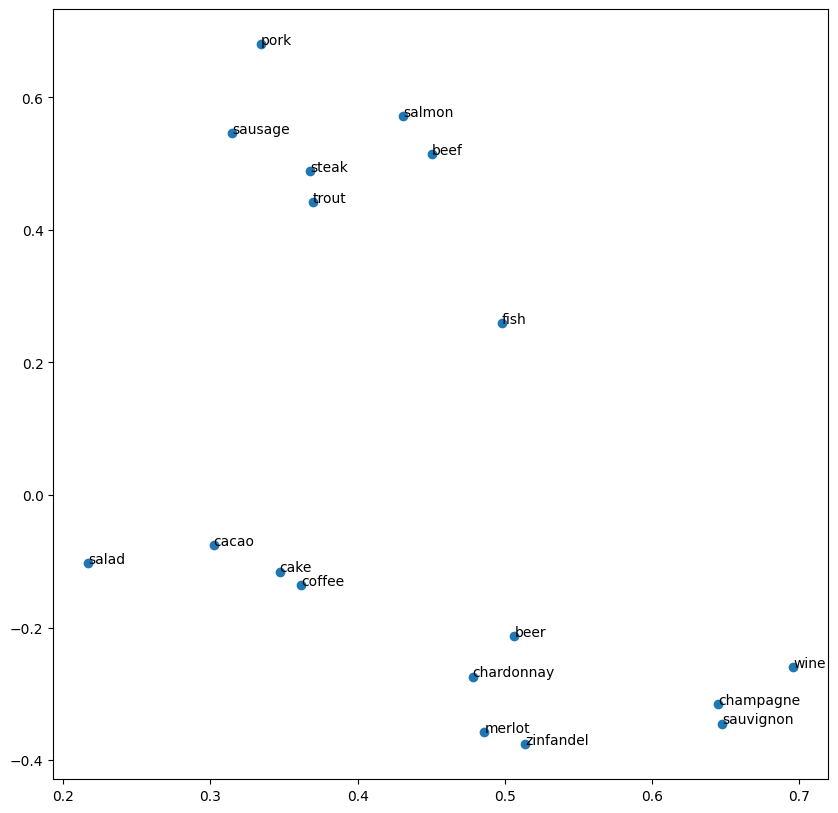

In [85]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake',
              'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 
              'chardonnay', 'champagne', 'cacao']
test_vectors = embed.get_vectors(*test_words)


fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)


Три кластера - напитки, мясо, алкоголь,

## Word2Vec при помощи Gensim

In [88]:
import gensim

In [93]:
word2vec = gensim.models.Word2Vec(sentences=train_tokens, vector_size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, epochs=10)

In [94]:
gensim_words = [w for w in test_words if w in word2vec.wv.key_to_index]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

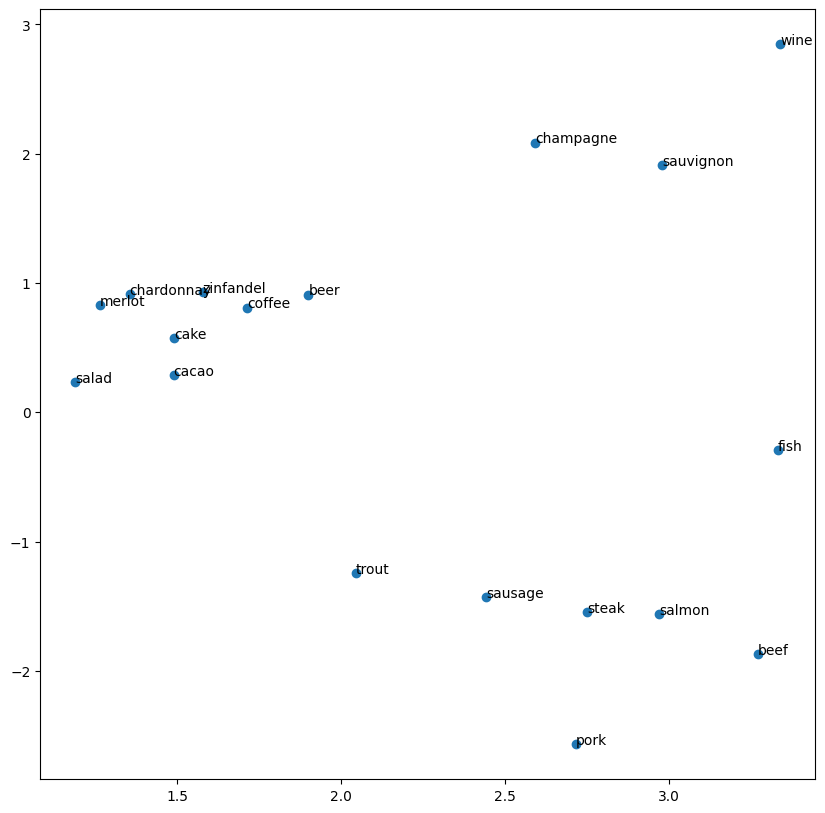

In [95]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

Три кластера - напитки, мясо, алкоголь

# В данном .ipynb приведены две реализации Word2Vec с точки зрения дистрибутивной семантики (векторов смыслов) - через Pytorch и Gensim